<h1> UNSUPERVISED LEARNING

In [27]:
import pyodbc
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

<h3> inlezen data van sql server

In [ ]:

# Verbindingsgegevens
server = '127.0.0.1'        
port = '1433'               
database = 'GreatOutdoorsSDM'         
username = 'SA'             
password = 'iDTyjZx7dRL4'  

# Connection string
connection_string = (
    f"DRIVER={{ODBC Driver 17 for SQL Server}};"
    f"SERVER={server},{port};"
    f"DATABASE={database};"
    f"UID={username};"
    f"PWD={password};"
    "TrustServerCertificate=yes;"
    "Timeout=30;"
)

# Maak verbinding met de database
conn = pyodbc.connect(connection_string)
cursor = conn.cursor()

sales_branch = pd.read_sql("SELECT * FROM sales_branch", conn)  
country = pd.read_sql("SELECT * FROM country", conn)
sales_territory = pd.read_sql("SELECT * FROM sales_territory", conn)
sales_staff = pd.read_sql("SELECT * FROM sales_staff", conn)
order_header = pd.read_sql("SELECT * FROM order_header", conn)
order_details = pd.read_sql("SELECT * FROM order_details", conn)    

# Aantal medewerkers per sales branch
staff_count = sales_staff.groupby("SALES_BRANCH_CODE").agg(NUM_EMPLOYEES=("SALES_STAFF_CODE", "count")).reset_index()

# Aantal orders per sales branch
order_count = order_header.groupby("SALES_BRANCH_CODE").agg(TOTAL_ORDERS=("ORDER_NUMBER", "count")).reset_index()


sales_branch = sales_branch.merge(staff_count, on="SALES_BRANCH_CODE", how="left")
sales_branch = sales_branch.merge(order_count, on="SALES_BRANCH_CODE", how="left")


sales_branch = sales_branch.merge(country, on="COUNTRY_CODE", how="left")
sales_branch = sales_branch.merge(sales_territory, on="SALES_TERRITORY_CODE", how="left")
sales_branch = sales_branch.merge(sales_staff, on="SALES_BRANCH_CODE", how="left")
sales_branch = sales_branch.merge(order_header, on="SALES_BRANCH_CODE", how="left")
sales_branch = sales_branch.merge(order_details, on="ORDER_NUMBER", how="left")



/var/folders/8f/wsxf5dvj0d31pnwb5zm1pkjr0000gn/T/ipykernel_65597/318334689.py:23: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  sales_branch = pd.read_sql("SELECT * FROM sales_branch", conn)
/var/folders/8f/wsxf5dvj0d31pnwb5zm1pkjr0000gn/T/ipykernel_65597/318334689.py:24: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  country = pd.read_sql("SELECT * FROM country", conn)
/var/folders/8f/wsxf5dvj0d31pnwb5zm1pkjr0000gn/T/ipykernel_65597/318334689.py:25: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  sales_territory = pd.read_sql

<h3> relevante data overhouden

In [21]:
sales_branch = sales_branch[['SALES_BRANCH_CODE','COUNTRY_EN','TERRITORY_NAME_EN','NUM_EMPLOYEES','TOTAL_ORDERS']]

x = sales_branch[['COUNTRY_EN','TERRITORY_NAME_EN','NUM_EMPLOYEES','TOTAL_ORDERS']]

x_encoded = pd.get_dummies(x, drop_first=True)

x_encoded.columns.to_list()


['NUM_EMPLOYEES',
 'TOTAL_ORDERS',
 'COUNTRY_EN_Austria',
 'COUNTRY_EN_Belgium',
 'COUNTRY_EN_Brazil',
 'COUNTRY_EN_Canada',
 'COUNTRY_EN_China',
 'COUNTRY_EN_Finland',
 'COUNTRY_EN_France',
 'COUNTRY_EN_Germany',
 'COUNTRY_EN_Italy',
 'COUNTRY_EN_Japan',
 'COUNTRY_EN_Korea',
 'COUNTRY_EN_Mexico',
 'COUNTRY_EN_Netherlands',
 'COUNTRY_EN_Spain',
 'COUNTRY_EN_Sweden',
 'COUNTRY_EN_Switzerland',
 'COUNTRY_EN_Taiwan',
 'COUNTRY_EN_United Kingdom',
 'COUNTRY_EN_United States',
 'TERRITORY_NAME_EN_Asia Pacific',
 'TERRITORY_NAME_EN_Central Europe',
 'TERRITORY_NAME_EN_Northern Europe',
 'TERRITORY_NAME_EN_Southern Europe']

<h3> data scalen

In [23]:
scaler = StandardScaler()
x_scaled = scaler.fit_transform(x_encoded)


#Waarom belangrijk?
#Stel dat één feature TOTAL_ORDERS heeft waarden tussen 10 en 100, en een andere feature NUM_EMPLOYEES ligt tussen 1 en 10. 
# Dan zou TOTAL_ORDERS veel meer invloed hebben op de clustering, puur omdat het een grotere schaal heeft. Standaardisatie voorkomt dat.

<h3> Clustermodel bouwen

In [61]:
kmeans = KMeans(n_clusters=8, random_state=42)
sales_branch["CLUSTER"] = kmeans.fit_predict(x_scaled)

pd.Series(kmeans.labels_).value_counts()



4    43286
3    30075
6    15952
5    14217
1    12570
2    12310
0    11580
7     8412
Name: count, dtype: int64

In [62]:
sales_branch.groupby("CLUSTER").mean(numeric_only=True)
sales_branch.groupby("CLUSTER")["COUNTRY_EN"].value_counts()


CLUSTER  COUNTRY_EN    
0        Canada            11580
1        Netherlands       12570
2        Italy              6060
         Austria            3460
         Spain              2790
3        United Kingdom    14216
         Germany            8045
         Belgium            4088
         Switzerland        3726
4        United States     39737
         Mexico             3549
5        Australia          5675
         Japan              3112
         Brazil             1662
         China              1370
         Taiwan             1200
         Korea              1198
6        Sweden            13804
         Finland            2148
7        France             8412
Name: count, dtype: int64

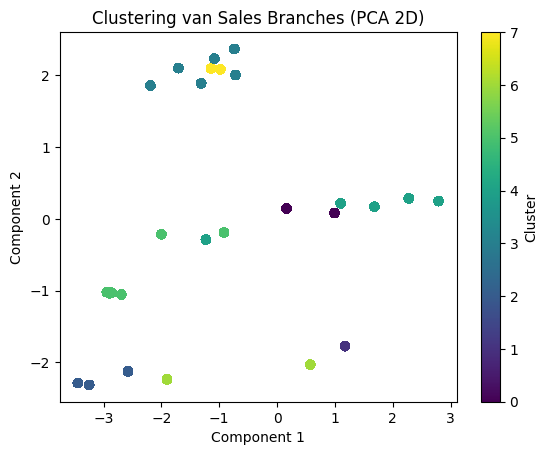

In [63]:
pca = PCA(n_components=2)
components = pca.fit_transform(x_scaled)

plt.scatter(components[:,0], components[:,1], c=sales_branch["CLUSTER"])
plt.title("Clustering van Sales Branches (PCA 2D)")
plt.xlabel("Component 1")
plt.ylabel("Component 2")
plt.colorbar(label="Cluster")
plt.show()

<h3> conclusie
<h5> ik heb uiteindelijk gekozen voor 8 clusters omdat de clusterverdeling dan het minst scheef is (de data is dus niet enorm verdeeld per cluster, maar best netjes onderverdeeld)

ik vond 4 clusters ook wel wat hebben qua visuele output, maar in sommige clusters was de data te dominant, wat niet goed is volgens internet